In [1]:
##################################################
####### Method: LR with nonlinear terms ##########
##################################################
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from netCDF4 import Dataset
from functionsLR_nonlinear import *
from datetime import datetime
from itertools import combinations 
from sklearn.preprocessing import PolynomialFeatures
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
# np.random.seed(42)

num_cores = multiprocessing.cpu_count()
print('Number of cores:',num_cores)

# Define other parameters of the problem
n_pc = 150         # number of PCs
n_record = 50000   # total records
n_maxtrain = 40000 # maximum possible length of training data
n_test = n_record - n_maxtrain # length of the test data
n_train = n_maxtrain
test0_idx = 40000   # test data start index
dt = 10             # temporal resolution

#### Load the pcs ####
f = 'psi1_DG_0_500K_100days_filtered_150PCs.dat'
pcs = dlmread(f, n_record)
pcs = center(pcs)
# get the test dataset
test_data = pcs[test0_idx:test0_idx+n_test, :n_pc]
 
#### Load the EOFs ####
nx = 513; ny=513
eoffile = os.getcwd() + '/../psi1_DG_0_500K_100days_filtered_150EOFs.nc'
fid = Dataset(eoffile,'r')
eofs = fid.variables['EOFs'][:]
eofs = eofs.reshape((n_pc, nx*ny))

Number of cores: 24


In [2]:
# compute the training dataset
x_train, y_train, scaler = training4tendency(pcs, n_pc, n_train, dt, 'standard_top_pc')

In [3]:
#######################################################
################# Linear Regression  ##################
#######################################################
degree = 1
[model_deg1, reg_res_deg1, r2_score_deg1] = linear_regression(x_train,y_train,degree,False)
degree = 2
[model_deg2, reg_res_deg2, r2_score_deg2] = linear_regression(x_train,y_train,degree,False)

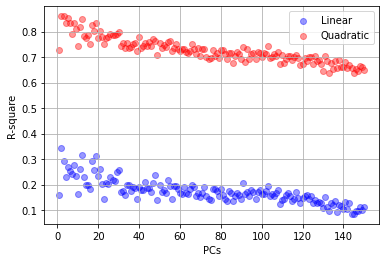

In [12]:
# Analyze rsquare values of the PCs for the two degrees of LR
plt.scatter(np.arange(1,n_pc+1,1), r2_score_deg1, color='b', alpha=0.4, label='Linear')
plt.scatter(np.arange(1,n_pc+1,1), r2_score_deg2, color='r', alpha=0.4, label='Quadratic')
plt.xlabel('PCs')
plt.ylabel('R-square')
plt.grid()
plt.legend(loc='best')
plt.savefig('Rsquare_Psi1_LR_degree=1and2_npc=150_ntrain=400K.png')
plt.show()

In [15]:
#### compute rsquare values ###
def rsquare(model,predictor,x,y,n_pc):
    r2_score = np.zeros(n_pc)
    # Residual sum of squares
    rss = np.sum((y - model.predict(predictor))**2, axis=0)
    # Total sum of squares
    tss = np.sum((y - np.mean(y, axis=0))**2, axis=0)
    # R2 score = 1 - rss/tss 
    r2_score = 1 - rss/tss
    
    return r2_score

In [16]:
rquare_degree2 = rsquare(linregmodel,predictor,x_train,y_train,n_pc)

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [ ]:
####################################################################
#################### Short term forecasts ##########################
####################################################################
n_maxlead = 10  # maximum lead time steps for forecasts
n_ic = int((n_test - n_maxlead))    # Number of initial conditions 
y_pred_degree2 = np.zeros([n_ic, n_maxlead, n_pc])

start = datetime.now()
for k in range(n_ic):
    #### Start Forecasts ####
    x_start = test_data[k,:]
    
    y_pred_degree2[k,:,:] = forecast(n_maxlead,n_pc,x_start,
                             dt,linregmodel,poly,scaler)

print('Prediction time:', datetime.now()-start)
print('Number of initial conditions:',n_ic)
print('Length of each forecast:',n_maxlead)

In [8]:
def RMSE(k,y_true,y_pred,eofs,n_maxlead):
    psi1_true = y_true[k+1:k+n_maxlead+1,:].dot(eofs)
    psi1_pred = y_pred[k,:,:].dot(eofs)
    return np.sqrt(np.mean((psi1_true - psi1_pred)**2, axis=1))

In [9]:
####################################################################
################# RMSE on the physical space #######################
###### Use each data point of the test dataset as an IC ############
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse_degree2 = np.zeros((n_ic, n_maxlead))

# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse_degree2 = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,y_pred_degree2,eofs,n_maxlead) for i in tqdm(range(n_ic)))

In [10]:
meanRMSE_degree2 = np.mean(rmse_degree2, axis=0)

In [11]:
np.save('RMSE_Psi1_100days_predictions_LR_degree=2_npc=150_nic=9990_ntrain=400K_ntest=100K',meanRMSE_degree2)